# **Misclassification spotter**


Example application of spectrogram approach to identify misclassified audios in a dataset

## Libraries

In [3]:
import os
import pandas as pd
import librosa.display
import numpy as np
from pandas.core.common import flatten
import datetime
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import scipy
import pickle
from pathlib import Path

In [4]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

## Load dataset

In [9]:
dftype = "reduced"
spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl"))

labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

embedding_filename = 'basic_UMAP_'+dftype+'_default_params_denoised.csv'
embedding = np.loadtxt(os.path.join(os.path.sep, DATA, embedding_filename),delimiter=";")

# Spotter

## Find nearest neighbors

In [10]:
k=5

nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [13]:
label_col = 'call_lable'
labels = spec_df[label_col].tolist()

In [15]:
wrong_neighbors = []
wrong_neighbors_row_num = []
wrong_datapoint = []
wrong_rownum = []

for i in range(spec_df.shape[0]):
    datapoint_label = labels[i]
    neighbors = indices[i]
    neighbor_labels = [labels[x] for x in neighbors]
    
    if datapoint_label not in neighbor_labels:
        wrong_neighbors.append(neighbor_labels)
        wrong_neighbors_row_num.append(neighbors)
        wrong_datapoint.append(datapoint_label)
        wrong_rownum.append(i)

In [16]:
len(wrong_neighbors)

572

In [17]:
wrong_df = pd.DataFrame(list(zip(wrong_rownum, wrong_datapoint)), 
               columns =['row_num', 'call_lable']) 

wrong_neighbors_arr = np.vstack(wrong_neighbors)

for i in range(wrong_neighbors_arr.shape[1]):
    col_name = "neighbor_"+str(i+1)
    wrong_df[col_name] = wrong_neighbors_arr[:,i]

wrong_neighbors_row_num_arr = np.vstack(wrong_neighbors_row_num)

for i in range(wrong_neighbors_row_num_arr.shape[1]):
    col_name = "neighbor_"+str(i+1)+"_rownum"
    wrong_df[col_name] = wrong_neighbors_row_num_arr[:,i]

wrong_df

,row_num,call_lable,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_1_rownum,neighbor_2_rownum,neighbor_3_rownum,neighbor_4_rownum,neighbor_5_rownum
0,7,agg,cc,soc,cc,ld,mo,6125,774,5281,677,4825
1,9,agg,soc,soc,soc,soc,soc,1316,2182,2056,2205,2181
2,15,al,soc,soc,cc,cc,agg,1306,2195,5231,5818,2320
3,16,al,sn,sn,sn,sn,sn,492,1004,1002,1008,1040
4,17,al,cc,soc,cc,cc,agg,5851,2624,4974,4998,4228
...,...,...,...,...,...,...,...,...,...,...,...,...
567,6368,cc,ld,soc,ld,mo,ld,621,920,1344,3671,4919
568,6390,cc,sn,sn,sn,sn,sn,888,1041,3518,747,1021
569,6393,cc,soc,soc,soc,mo,soc,729,2697,724,2673,873
570,6412,cc,sn,sn,sn,sn,sn,753,494,272,483,443


### Descriptive statistics

In [18]:
wrong_df['call_lable'].value_counts()

soc    137
al     105
agg     84
cc      75
ld      60
mo      60
sn      51
Name: call_lable, dtype: int64

In [62]:
w = pd.DataFrame(wrong_df['call_lable'].value_counts())
w.sort_index(inplace=True)

a = pd.DataFrame(spec_df[label_col].value_counts())
a.sort_index(inplace=True)

In [63]:
tab = pd.DataFrame({'mispositioned': w['call_lable'], 'overall': a[label_col], 'percentage': 100*(w['call_lable']/a[label_col])})
tab

,mispositioned,overall,percentage
agg,84,375,22.400000
al,105,646,16.253870
cc,75,1477,5.077861
ld,60,164,36.585366
mo,60,759,7.905138
sn,51,1855,2.749326
soc,137,1154,11.871750


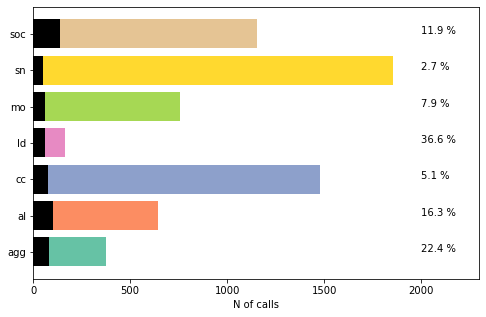

In [64]:
fig = plt.figure(figsize=(8,5))
labelcounts = pd.DataFrame(spec_df[label_col].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts[label_col].values, color = pal)
plt.barh(labelcounts.index, tab.mispositioned.values, color = 'black')
plt.xlabel("N of calls")
plt.xlim(0,2300)
for index, value in enumerate(tab.mispositioned.values):
    plt.text(2000, index, str(round(tab.loc[tab.index[index],'percentage'],1))+" %")

### Clear cases

Identify "clear" cases, where all neighbors are of the same label type.

In [27]:
nb_cols=[]
for i in range(k):
    nb_cols.append('neighbor_'+str(i+1))
nb_cols

['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']

In [28]:
clear_cases = []

for i in range(wrong_df.shape[0]):
    nbs = wrong_df.loc[i,nb_cols].tolist()
    if len(set(nbs))==1:
        clear_cases.append('yes')
    else:
        clear_cases.append('no')

In [29]:
wrong_df['clear_case'] = clear_cases
wrong_df.clear_case.value_counts()

no     338
yes    234
Name: clear_case, dtype: int64

Okay, for some calls, there seems to be a clear mislabeling. Plot some example calls:

In [30]:
wrong_df.head()

,row_num,call_lable,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_1_rownum,neighbor_2_rownum,neighbor_3_rownum,neighbor_4_rownum,neighbor_5_rownum,clear_case
0,7,agg,cc,soc,cc,ld,mo,6125,774,5281,677,4825,no
1,9,agg,soc,soc,soc,soc,soc,1316,2182,2056,2205,2181,yes
2,15,al,soc,soc,cc,cc,agg,1306,2195,5231,5818,2320,no
3,16,al,sn,sn,sn,sn,sn,492,1004,1002,1008,1040,yes
4,17,al,cc,soc,cc,cc,agg,5851,2624,4974,4998,4228,no


Remove unknown calls and only select clear cases

In [65]:
wrong_subset = wrong_df.loc[wrong_df['clear_case']=='yes']
wrong_subset = wrong_subset.loc[wrong_subset['call_lable']!='unk']

# Need to reset index, else won't be able to accces ith row of original dataframe
spec_df.reset_index(inplace=True)

calltypes = sorted(list(set(wrong_subset['call_lable'])))
calltypes

['agg', 'al', 'cc', 'ld', 'mo', 'sn', 'soc']

In [66]:
wrong_subset.head()

,row_num,call_lable,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_1_rownum,neighbor_2_rownum,neighbor_3_rownum,neighbor_4_rownum,neighbor_5_rownum,clear_case
1,9,agg,soc,soc,soc,soc,soc,1316,2182,2056,2205,2181,yes
3,16,al,sn,sn,sn,sn,sn,492,1004,1002,1008,1040,yes
6,21,al,cc,cc,cc,cc,cc,6251,5789,5976,5563,5978,yes
7,24,al,sn,sn,sn,sn,sn,1265,978,1295,1078,3477,yes
8,30,al,sn,sn,sn,sn,sn,1545,3530,261,1543,3545,yes


In [67]:
w = pd.DataFrame(wrong_subset['call_lable'].value_counts())
w.sort_index(inplace=True)

a = pd.DataFrame(spec_df[label_col].value_counts())
a.sort_index(inplace=True)

In [68]:
tab = pd.DataFrame({'mispositioned': w['call_lable'], 'overall': a[label_col], 'percentage': 100*(w['call_lable']/a[label_col])})
tab

,mispositioned,overall,percentage
agg,22,375,5.866667
al,49,646,7.585139
cc,21,1477,1.421801
ld,24,164,14.634146
mo,25,759,3.293808
sn,14,1855,0.754717
soc,79,1154,6.845754


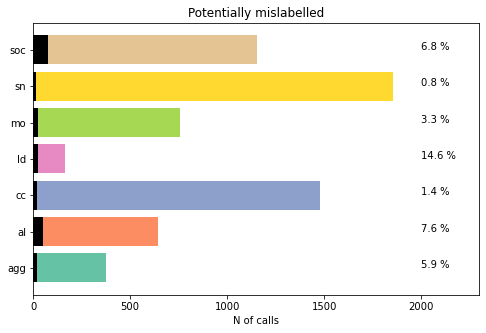

In [69]:
fig = plt.figure(figsize=(8,5))
labelcounts = pd.DataFrame(spec_df[label_col].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts[label_col].values, color = pal)
plt.barh(labelcounts.index, tab.mispositioned.values, color = 'black')
plt.xlabel("N of calls")
plt.title("Potentially mislabelled")
plt.xlim(0,2300)
for index, value in enumerate(tab.mispositioned.values):
    plt.text(2000, index, str(round(tab.loc[tab.index[index],'percentage'],1))+" %")

### Plot example misclassified calls

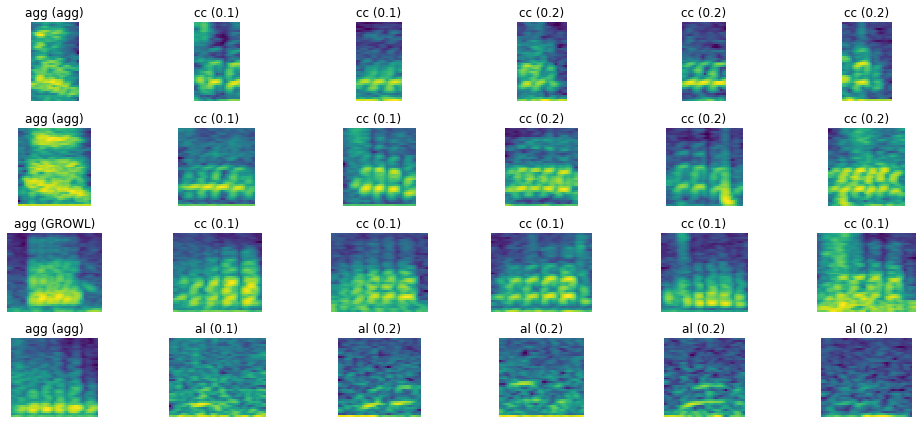

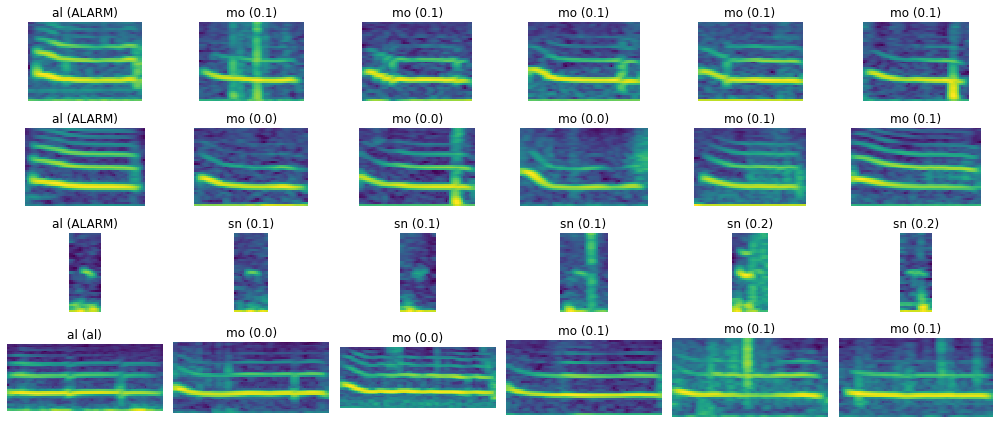

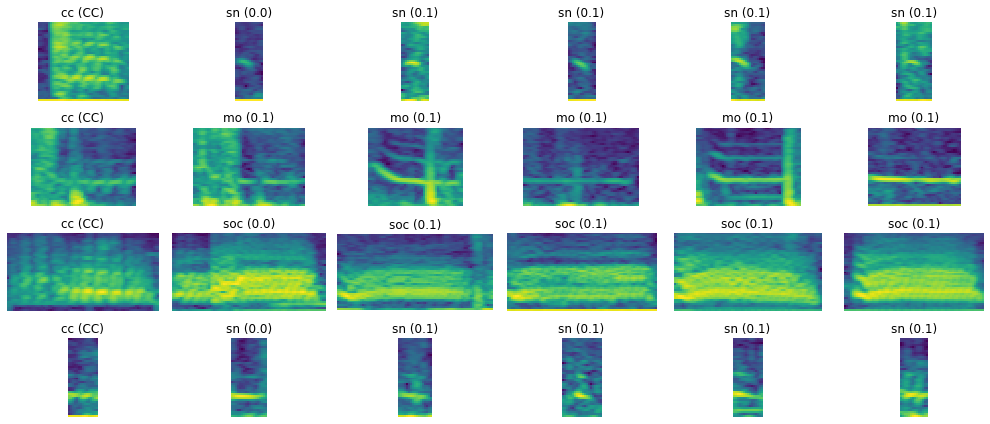

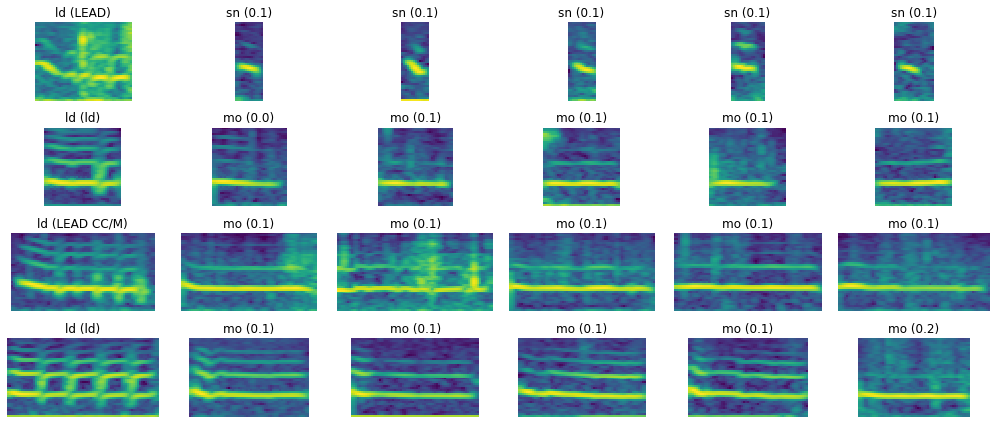

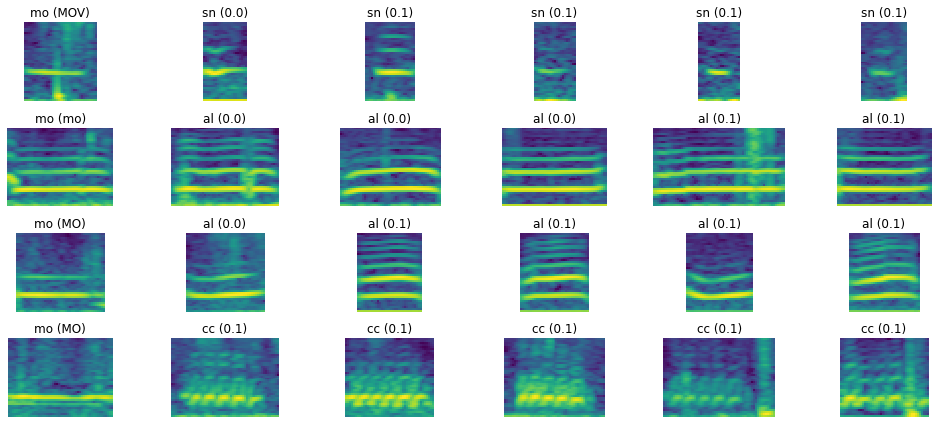

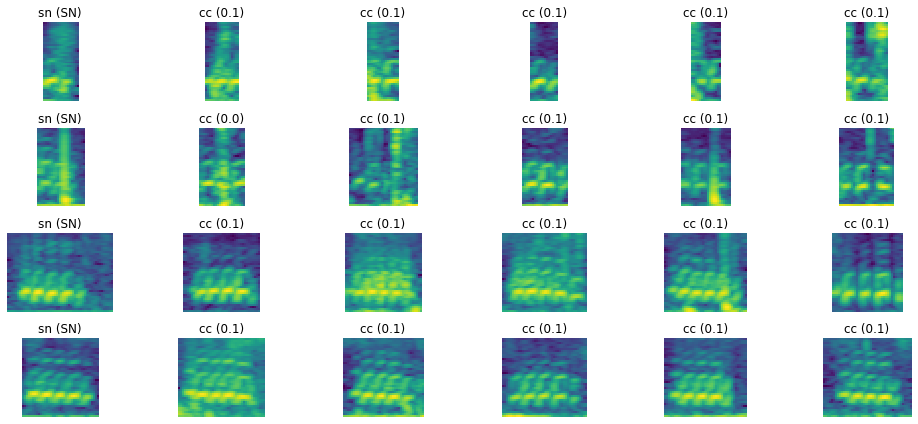

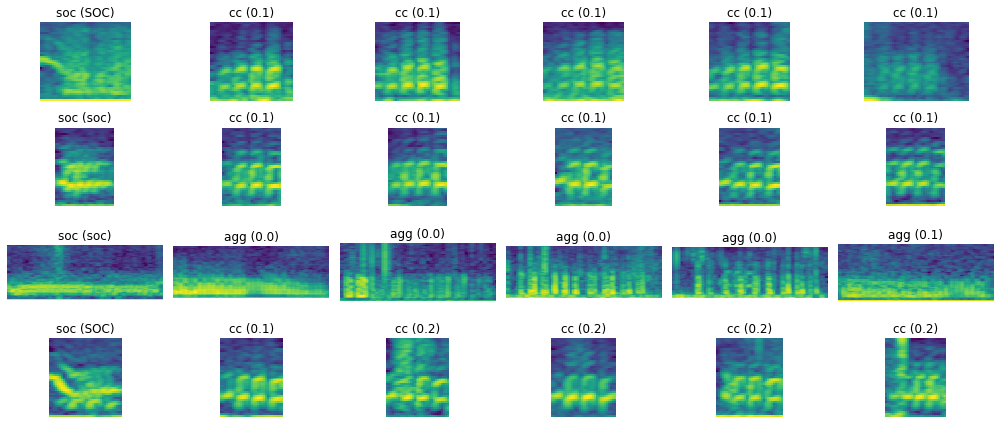

In [39]:
data=embedding
for calltype in calltypes:
    fig = plt.figure(figsize=(14,6))
    fig_name = 'NN_misclass_Viz_'+calltype
    p=1

    subset_df = wrong_subset.loc[wrong_subset['call_lable']==calltype,:]

      # randomly choose 4
    examples = subset_df.sample(n=4, random_state=2204)
    examples.reset_index(inplace=True)
  
    for i in range(examples.shape[0]):
        ori_rownum = examples.loc[i,'row_num']
        spec = spec_df.loc[ori_rownum,'spectrograms']
        plt.subplot(4, 6, p)
        plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
        plt.axis('off')
        original_name = spec_df.loc[ori_rownum,'Name']
        plt.title(calltype+" ("+original_name+")")
        p=p+1

        for neighbor in range(1,6):
            neighbor_label = examples.loc[i,'neighbor_'+str(neighbor)]
            nb_rownum = examples.loc[i,'neighbor_'+str(neighbor)+'_rownum']
            neighbor_spec = spec_df.loc[nb_rownum,'spectrograms']
            dist = scipy.spatial.distance.euclidean(data[ori_rownum,:], data[nb_rownum,:])
            plt.subplot(4, 6, p)
            plt.imshow(neighbor_spec, interpolation='nearest', origin='lower', aspect='equal') 
            plt.axis('off')
            plt.title(examples.loc[i,'neighbor_'+str(neighbor)]+" ("+str(round(dist,1))+")")
            p=p+1
        
    plt.tight_layout() 
    plt.savefig(os.path.join(os.path.sep,FIGURES,fig_name), facecolor="white")

### Random select calls for manual assignment

From the subset of clearly misclassified calls, select a reasonable amount that Vlad and Baptiste can go through manually and check.

In [70]:
random_subset = wrong_subset.sample(n=100, random_state=1)
random_subset

,row_num,call_lable,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_1_rownum,neighbor_2_rownum,neighbor_3_rownum,neighbor_4_rownum,neighbor_5_rownum,clear_case
453,4689,mo,cc,cc,cc,cc,cc,5418,5286,5103,5819,6159,yes
180,1330,ld,mo,mo,mo,mo,mo,720,3858,4211,644,2543,yes
570,6412,cc,sn,sn,sn,sn,sn,753,494,272,483,443,yes
112,781,soc,sn,sn,sn,sn,sn,1568,3447,3493,3463,3513,yes
341,3542,soc,sn,sn,sn,sn,sn,211,1139,1169,3216,233,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,1302,soc,agg,agg,agg,agg,agg,4203,4200,4201,4208,4206,yes
181,1331,sn,cc,cc,cc,cc,cc,5393,5255,5342,5722,5035,yes
472,4821,mo,al,al,al,al,al,3883,4046,4047,3884,4048,yes
270,2127,ld,al,al,al,al,al,2210,2571,2405,2398,2424,yes


In [72]:
random_subset['spectrograms'] = [spec_df.loc[x,'spectrograms'] for x in random_subset.row_num]
random_subset['raw_audio'] = [spec_df.loc[x,'raw_audio'] for x in random_subset.row_num]
random_subset['samplerate_hz'] = [spec_df.loc[x,'samplerate_hz'] for x in random_subset.row_num]
random_subset['Name'] = [spec_df.loc[x,'Name'] for x in random_subset.row_num]
random_subset['nb_audio'] = [spec_df.loc[x,'raw_audio'] for x in random_subset.neighbor_1_rownum]
random_subset['nb_samplerate_hz'] = [spec_df.loc[x,'samplerate_hz'] for x in random_subset.neighbor_1_rownum]

In [73]:
for nb_num in range(1,6):
    random_subset['nb_'+str(nb_num)+'audio'] = [spec_df.loc[x,'raw_audio'] for x in random_subset['neighbor_'+str(nb_num)+'_rownum']]
    random_subset['nb_'+str(nb_num)+'samplerate_hz'] = [spec_df.loc[x,'samplerate_hz'] for x in random_subset['neighbor_'+str(nb_num)+'_rownum']]
    random_subset['nb_'+str(nb_num)+'spectrograms'] = [spec_df.loc[x,'spectrograms'] for x in random_subset['neighbor_'+str(nb_num)+'_rownum']]

In [74]:
random_subset.reset_index(inplace=True)

#### Save calls

In [75]:
outname = os.path.join(os.path.sep, DATA, 'random_sub_missclassi')
print(outname)
random_subset.to_pickle(outname+'.pkl')
random_subset.to_json(outname+'.json', orient = 'split', compression = 'infer', index = 'true')

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/random_sub_missclassi


In [51]:
#random_subset.samplerate_hz.value_counts()

8000     43
48000     7
Name: samplerate_hz, dtype: int64

### Save random subset wavs

In [107]:
#random_subset.head(3)

,index,row_num,call_lable,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_1_rownum,neighbor_2_rownum,...,nb_2spectrograms,nb_3audio,nb_3samplerate_hz,nb_3spectrograms,nb_4audio,nb_4samplerate_hz,nb_4spectrograms,nb_5audio,nb_5samplerate_hz,nb_5spectrograms
0,453,4689,mo,cc,cc,cc,cc,cc,5418,5286,...,"[[-29.437366, -29.528278, -26.986982, -25.2291...","[-0.015625, -0.015625, -0.01171875, -0.015625,...",8000,"[[-12.554695, -12.13283, -12.208527, -12.51190...","[-0.017578125, -0.015625, -0.015625, -0.017578...",8000,"[[-25.24755, -25.866062, -24.013737, -19.73333...","[0.03125, 0.025390625, 0.02734375, 0.03515625,...",8000,"[[-22.768295, -23.133165, -23.478321, -23.1183..."
1,180,1330,ld,mo,mo,mo,mo,mo,720,3858,...,"[[-5.8478727, -5.2114763, -4.1648817, -3.65625...","[-0.00390625, -0.005859375, -0.01171875, -0.01...",8000,"[[-25.284197, -25.35957, -25.522158, -25.87941...","[-0.0234375, -0.025390625, -0.025390625, -0.02...",8000,"[[-2.682603, -2.5846071, -2.1913977, -1.382401...","[-0.021484375, -0.017578125, -0.01171875, -0.0...",8000,"[[-3.384451, -3.525835, -3.6908474, -3.6089478..."
2,570,6412,cc,sn,sn,sn,sn,sn,753,494,...,"[[-2.8468237, -2.5435476, -2.574811, -3.896620...","[0.087890625, 0.10546875, 0.095703125, 0.09765...",8000,"[[0.0, -0.3973056, -1.8321108, -4.7265596, -8....","[-0.015625, -0.017578125, -0.015625, -0.015625...",8000,"[[-4.0047913, -4.068576, -4.690442, -5.6354475...","[0.00390625, 0.00390625, 0.001953125, 0.003906...",8000,"[[-9.596747, -6.103488, -3.3793535, -3.1499805..."


### Wavs

In [83]:
MISCLASSI_OUT = os.path.join(os.path.sep, DATA, 'misclassi_calls')

if (not os.path.isdir(MISCLASSI_OUT)):
    os.mkdir(MISCLASSI_OUT)

In [85]:
# Need to resample all at same samplerate!!!!
import soundfile as sf
from scipy.io import wavfile
import scipy.signal as sps

SR = 8000

def write_wav(uid, data, sr):
    filename = str(uid)+'.wav'
    if sr == SR:
        sf.write(filename, data, sr, subtype='PCM_16')
    else: # resample
        print("Resampled for "+filename)
        number_of_samples = round(len(data) * float(SR) / sr)
        data = sps.resample(data, number_of_samples)
        sf.write(filename, data, SR, subtype='PCM_16')

os.chdir(MISCLASSI_OUT)
x=random_subset.apply(lambda row: write_wav(row['index'], row['raw_audio'], row['samplerate_hz']), axis=1)

Resampled for 453.wav
Resampled for 494.wav
Resampled for 487.wav
Resampled for 252.wav
Resampled for 449.wav
Resampled for 490.wav
Resampled for 517.wav
Resampled for 466.wav
Resampled for 195.wav
Resampled for 245.wav
Resampled for 457.wav
Resampled for 510.wav
Resampled for 243.wav
Resampled for 472.wav


### Spec imgs

In [94]:
MISCLASSI_IMG_OUT = os.path.join(os.path.sep, DATA, 'misclassi_imgs')

if (not os.path.isdir(MISCLASSI_IMG_OUT)):
    os.mkdir(MISCLASSI_IMG_OUT)

In [100]:
n_ticks=3
FFT_WIN = 0.03
FFT_HOP = FFT_WIN/8
HOP_LEN = int(0.03*SR)
FMAX = 4000

for i in range(random_subset.shape[0]):
#for i in range(3):
    plt.figure(figsize=(12, 2))
    outname = str(random_subset.loc[i,'index'])+'.jpg'
    ori_rownum = random_subset.loc[i,'row_num']
    spec = spec_df.loc[ori_rownum,'spectrograms']
    plt.subplot(1, 6, 1)
    librosa.display.specshow(spec,sr=SR, hop_length=HOP_LEN , fmax=FMAX, y_axis='mel', cmap='inferno')

    # Generate axis labels
    #n_frames = spec.shape[1]
    duration = FFT_HOP*spec.shape[1]
    step_size = round(duration/n_ticks,2)
    myticks = np.arange(0,duration, step_size)
    plt.xticks([round(x/FFT_HOP,0) for x in myticks], [str(round(x,2)) for x in myticks])

    plt.title(spec_df.loc[ori_rownum,'call_lable'])
    p=2


    for neighbor in range(1,6):
        neighbor_label = random_subset.loc[i,'neighbor_'+str(neighbor)]
        nb_rownum = random_subset.loc[i,'neighbor_'+str(neighbor)+'_rownum']
        neighbor_spec = spec_df.loc[nb_rownum,'spectrograms']
        plt.subplot(1, 6, p)
        librosa.display.specshow(neighbor_spec,sr=SR, hop_length=HOP_LEN , fmax=FMAX, cmap='inferno')
        plt.xticks([round(x/FFT_HOP,0) for x in myticks], [str(round(x,2)) for x in myticks])
        plt.title(random_subset.loc[i,'neighbor_'+str(neighbor)])
        p=p+1

    plt.savefig(os.path.join(os.path.sep, MISCLASSI_IMG_OUT, outname))
    plt.close()


#### Info file

In [103]:
outname = os.path.join(os.path.sep, DATA, 'info.csv')
random_subset[['index', 'call_lable', 'neighbor_1']].to_csv(outname, index=False)

In [106]:
x=pd.read_csv(outname)
x

,index,call_lable,neighbor_1
0,453,mo,cc
1,180,ld,mo
2,570,cc,sn
3,112,soc,sn
4,341,soc,sn
...,...,...,...
95,174,soc,agg
96,181,sn,cc
97,472,mo,al
98,270,ld,al
